In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch # to use PennyLane TorchLayer class to perform circuit operations and optimisations with PyTorch backend
from matplotlib import pyplot as plt

from utils.tools import get_dataset, visualise_data

2025-04-30 12:11:17.064872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745979077.081194   65013 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745979077.086206   65013 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745979077.098857   65013 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745979077.098872   65013 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745979077.098874   65013 computation_placer.cc:177] computation placer alr

I0000 00:00:1745979079.047126   65013 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10759 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:02:00.0, compute capability: 6.0


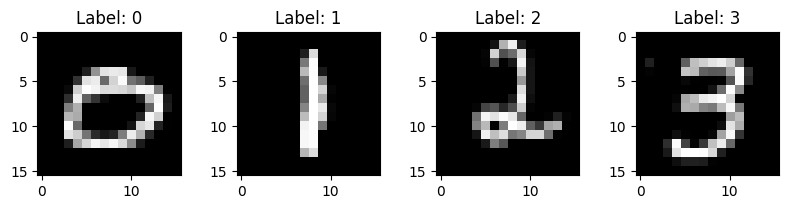

In [2]:
digits = [0,1,2,3]
n_px = 16

(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

# show one image from each class
x_vis = [(x_train[y_train==digit])[np.random.choice(range(10))] for digit in digits] 
y_vis = range(len(digits))

visualise_data(digits, x_vis, y_vis)

In [3]:
X_train = np.reshape(x_train, (len(x_train), n_px, n_px))
X_test = np.reshape(x_test, (len(x_test), n_px, n_px))
Y_train = y_train
Y_test = y_test

print('X')
print(f'Shape : {X_train.shape}')
print(f'dType : {X_train.dtype}')
print(f'pyType: {type(X_train)}')

print('Y')
print(f'Shape : {Y_train.shape}')
print(f'dType : {Y_train.dtype}')
print(f'pyType: {type(Y_train)}')

X
Shape : (1000, 16, 16)
dType : float32
pyType: <class 'pennylane.numpy.tensor.tensor'>
Y
Shape : (1000,)
dType : uint8
pyType: <class 'numpy.ndarray'>


In [6]:
#### Hyperparameters ####
input_dim = n_px * n_px # 16 X 16 pixels
num_classes = len(digits)
num_layers = 32
num_qubits = 8
num_reup = 3

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)


class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

Using device: cpu


In [7]:
import time
t = time.time()
#### Hyperparameters ####
learning_rate = 0.1
epochs = 4
batch_size = 20

# we use a subset of the training and validation data for this tutorial to speed up the training
n_train = 400
n_test = 100

feats_train = torch.from_numpy(X_train[:n_train]).reshape(n_train, -1).to(device)
feats_test = torch.from_numpy(X_test[:n_test]).reshape(n_test, -1).to(device)
labels_train = torch.from_numpy(Y_train[:n_train]).to(device)
labels_test = torch.from_numpy(Y_test[:n_test]).to(device)
num_train = feats_train.shape[0]

# initialize the model, loss function and optimization algorithm (Adam optimizer)
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size


# set up a measure for performance
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc


# generate randomly permutated batches to speed up training
def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


# display accuracy and loss after each epoch (to speed up runtime, only do this for first 100 samples)
def print_acc(epoch, max_ep=4):
    predictions_train = [qml_model(f) for f in feats_train[:50]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:50], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )


print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

# optimize over model parameters for given number of epochs
for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs)

elapsed = time.time() - t
print(f"\nTime elapsed: {elapsed} s.")

Starting training loop for quantum variational classifier (8 qubits, 32 layers)...
Epoch 0/4 | Approx Cost (train): 1.3835318 | Cost (val): 1.3829010 | Approx Acc train: 0.3000000 | Acc val: 0.2700000
Epoch 1/4 | Approx Cost (train): 1.2503847 | Cost (val): 1.2510983 | Approx Acc train: 0.6600000 | Acc val: 0.6700000
Epoch 2/4 | Approx Cost (train): 1.2095851 | Cost (val): 1.1875492 | Approx Acc train: 0.6600000 | Acc val: 0.6800000
Epoch 3/4 | Approx Cost (train): 1.1719388 | Cost (val): 1.1515929 | Approx Acc train: 0.7200000 | Acc val: 0.8100000
Epoch 4/4 | Approx Cost (train): 1.1225013 | Cost (val): 1.1072137 | Approx Acc train: 0.7200000 | Acc val: 0.7900000

Time elapsed: 322.22449254989624 s.


In [50]:
print(qml.draw(qml_model.qcircuit, level="device"))

<function QML_classifier.__init__.<locals>.circuit at 0x7f321d33e7a0>


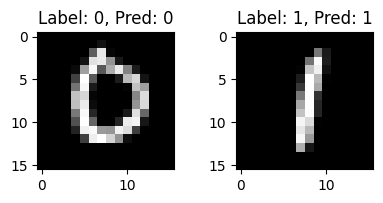

In [54]:
# show accuracy
x_vis_torch = torch.from_numpy(np.array(x_vis).reshape(num_classes, -1))
y_vis_torch = torch.from_numpy(np.array(y_vis))
benign_preds = [qml_model(f) for f in x_vis_torch]

benign_class_output = [torch.argmax(p) for p in benign_preds]
visualise_data(digits, x_vis, y_vis, benign_class_output)

In [55]:
# simple implementation of projected gradient descent (PGD) attack (without randomized starting points — cf. BIM)
# for an introduction to PGD, see https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent
def PGD(model, feats, labels, epsilon=0.1, alpha=0.1, num_iter=10):

    # initialize image perturbations with zero
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]

        # forward & backward pass through the model, accumulating gradients
        l = loss(torch.stack(outputs), labels)
        l.backward()

        # use gradients with respect to inputs and clip the results to lie within the epsilon boundary
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

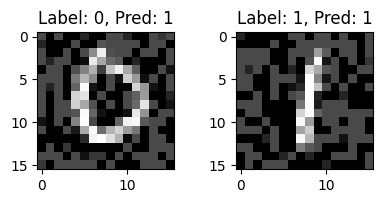

In [57]:
perturbations = PGD(model=qml_model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.2) # even smaller values of epsilon do some damage (epsilon > 0.04)
perturbed_x = x_vis_torch + perturbations

# check model performance
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualise_data(digits, perturbed_x.reshape(-1, n_px, n_px), y_vis, adversarial_class_output)

In [58]:
adv_dataset = (
    PGD(model=qml_model, feats=feats_train[:20], labels=labels_train[:20], epsilon=0.1)
    + feats_train[:20]
)

feats_retrain = torch.cat((feats_train, adv_dataset))
labels_retrain = torch.cat((labels_train, labels_train[:20]))
epochs_retraining = 2

for ep in range(0, epochs_retraining):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep, max_ep=2)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_retrain[batch_ind[it]]
        labels_train_batch = labels_retrain[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs_retraining, max_ep=2)

Epoch 0/2 | Approx Cost (train): 0.1785702 | Cost (val): 0.1729840 | Approx Acc train: 1.0000000 | Acc val: 1.0000000
Epoch 1/2 | Approx Cost (train): 0.1735246 | Cost (val): 0.1680840 | Approx Acc train: 1.0000000 | Acc val: 1.0000000
Epoch 2/2 | Approx Cost (train): 0.1720764 | Cost (val): 0.1666546 | Approx Acc train: 1.0000000 | Acc val: 1.0000000


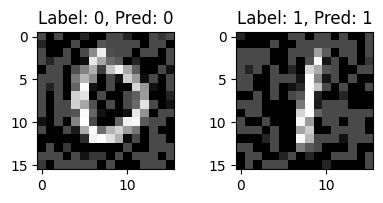

In [59]:
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualise_data(digits, perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

## Quantum model with amplitude embedding

In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
num_wires = 8
dev = qml.device("lightning.qubit", wires=num_wires)

@qml.qnode(dev)
def circuit(x, num_wires):
    qml.AmplitudeEmbedding(x, wires=range(num_wires))
    # qml.StronglyEntanglingLayers(weights=weights, wires=range(num_wires))

x = np.random.rand(8,8)
# weights = np.ran

print(qml.draw(circuit, level="device")(x, num_wires))

ValueError: State must be of length 256; got length 8. Use the 'pad_with' argument for automated padding.

In [3]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(f, parameters):
    qml.AmplitudeEmbedding(features=f, wires=range(4), normalize=True)
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return qml.expval(qml.Z(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(size=shape)
f = np.random.random(size=16)

In [4]:
print(qml.draw(circuit, level="device")(f, weights))

0: ─╭|Ψ⟩──Rot(0.76,0.01,0.01)─╭●───────╭X──Rot(0.75,0.57,0.53)─╭●────╭X────┤  <Z>
1: ─├|Ψ⟩──Rot(0.41,0.14,0.01)─╰X─╭●────│───Rot(0.69,0.42,0.03)─│──╭●─│──╭X─┤     
2: ─├|Ψ⟩──Rot(0.49,0.12,0.47)────╰X─╭●─│───Rot(0.25,0.28,0.00)─╰X─│──╰●─│──┤     
3: ─╰|Ψ⟩──Rot(0.18,0.12,0.03)───────╰X─╰●──Rot(0.99,0.60,0.30)────╰X────╰●─┤     


In [5]:
print(qml.draw(circuit, level="device")(f, weights))

0: ─╭|Ψ⟩──Rot(0.76,0.01,0.01)─╭●───────╭X──Rot(0.75,0.57,0.53)─╭●────╭X────┤  <Z>
1: ─├|Ψ⟩──Rot(0.41,0.14,0.01)─╰X─╭●────│───Rot(0.69,0.42,0.03)─│──╭●─│──╭X─┤     
2: ─├|Ψ⟩──Rot(0.49,0.12,0.47)────╰X─╭●─│───Rot(0.25,0.28,0.00)─╰X─│──╰●─│──┤     
3: ─╰|Ψ⟩──Rot(0.18,0.12,0.03)───────╰X─╰●──Rot(0.99,0.60,0.30)────╰X────╰●─┤     


In [8]:
n_px = 8
num_qubits = int(np.log2(n_px**2))
dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev)
def circuit(f, parameters):
    qml.AmplitudeEmbedding(features=f, wires=range(num_qubits), normalize=True)
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(num_qubits))
    return qml.expval(qml.Z(0))
 
shape = qml.StronglyEntanglingLayers.shape(n_layers=4, n_wires=num_qubits)
weights = np.random.random(size=shape)
f = x.flatten()

In [9]:
print(qml.draw(circuit, level="device")(f, weights))

0: ─╭|Ψ⟩──Rot(0.36,0.56,0.73)─╭●─────────────╭X──Rot(0.64,0.67,0.14)─╭●──────────╭X
1: ─├|Ψ⟩──Rot(0.01,0.51,0.35)─╰X─╭●──────────│───Rot(0.68,0.70,0.41)─│──╭●───────│─
2: ─├|Ψ⟩──Rot(0.13,0.24,0.68)────╰X─╭●───────│───Rot(0.99,1.00,0.35)─╰X─│──╭●────│─
3: ─├|Ψ⟩──Rot(0.71,0.79,0.90)───────╰X─╭●────│───Rot(0.63,0.17,0.96)────╰X─│──╭●─│─
4: ─├|Ψ⟩──Rot(0.11,0.77,0.84)──────────╰X─╭●─│───Rot(0.60,0.87,0.60)───────╰X─│──╰●
5: ─╰|Ψ⟩──Rot(0.40,0.85,0.98)─────────────╰X─╰●──Rot(0.45,0.74,0.12)──────────╰X───

───Rot(0.66,0.07,0.32)──────────────────────╭●───────╭X──Rot(0.19,0.11,0.89)─────────────────────
──╭X────────────────────Rot(0.16,0.91,0.35)─│──╭●────│──╭X────────────────────Rot(0.13,0.31,0.82)
──│─────────────────────Rot(0.88,0.35,0.71)─│──│──╭●─│──│────────────────────╭X──────────────────
──│─────────────────────Rot(0.85,0.69,0.75)─╰X─│──│──╰●─│────────────────────│───────────────────
──│─────────────────────Rot(0.66,0.38,0.05)────╰X─│─────╰●───────────────────│───────────────────
──╰●─

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [14]:
n_qubits = int(np.log2(n_px**2))

In [15]:
dev = qml.device("lightning.qubit", wires=range(n_qubits))

In [21]:
def layer(layer_weights):
    for wire in range(n_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

In [22]:
def state_preparation(x):
    qml.BasisState(x, wires=range(n_qubits))

In [23]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [24]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [25]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [26]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [27]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)